In [ ]:
!pip install roboflow

from google.colab import drive
drive.mount('/content/drive')

from roboflow import Roboflow
rf = Roboflow(api_key="IwbjvxFzcbBgxgAJv6M2")
project = rf.workspace("aslvsbsl").project("aslvsbsl")
version = project.version(1)
dataset = version.download("folder")

dataset_path = dataset.location

train_dir = f'{dataset_path}/train'
valid_dir = f'{dataset_path}/valid'
test_dir = f'{dataset_path}/test'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 729.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
Mounted at /content/drive
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ASLvsBSL-1 in folder:: 100%|██████████| 2435/2435 [00:02<00:00, 1211.09it/s]


Found 1600 images belonging to 10 classes.
Found 280 images belonging to 10 classes.
Found 520 images belonging to 10 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30
25/25 [==============================] - 79s 3s/step - loss: 2.0733 - accuracy: 0.3769 - val_loss: 1.6183 - val_accuracy: 0.3828 - lr: 1.0000e-04
Epoch 2/30
25/25 [==============================] - 70s 3s/step - loss: 0.7294 - accuracy: 0.7588 - val_loss: 0.8664 - val_accuracy: 0.6953 - lr: 1.0000e-04
Epoch 3/30
25/25 [==============================] - 69s 3s/step - loss: 0.4276 - accuracy: 0.8569 - val_loss: 0.5534 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 4/30
25/25 [==============================] - 70s 3s/step - loss: 0.2845 - accuracy: 0.9169 - val_loss: 0.3606 - val_accuracy: 0.9141 - lr: 1.0000e-04
Epoch 5/30
25/25 [==============================] - 68s 3s/step - loss: 0.2234 - accuracy: 0.9294 - val_loss: 0.2661 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 6/30
25/25 [=======

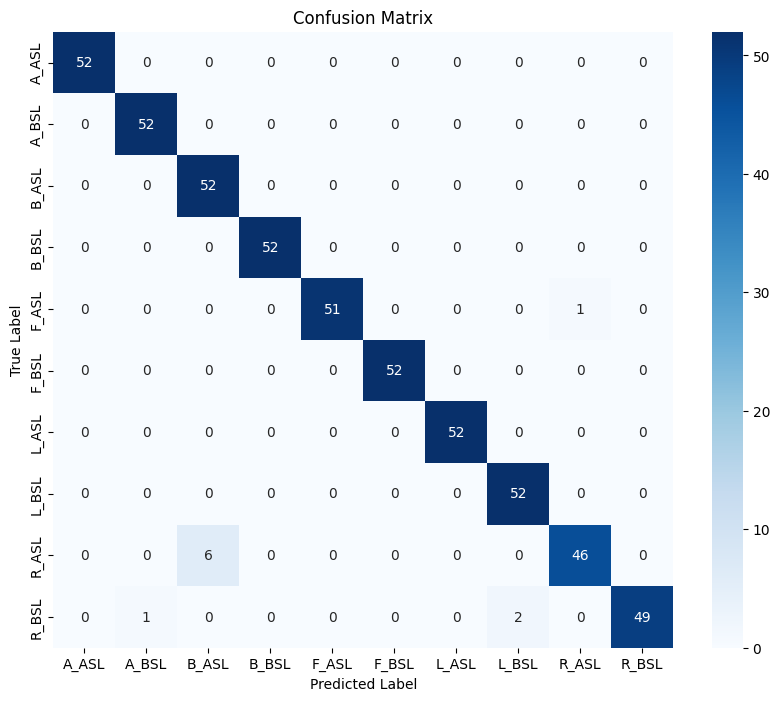

              precision    recall  f1-score   support

       A_ASL       1.00      1.00      1.00        52
       A_BSL       0.98      1.00      0.99        52
       B_ASL       0.90      1.00      0.95        52
       B_BSL       1.00      1.00      1.00        52
       F_ASL       1.00      0.98      0.99        52
       F_BSL       1.00      1.00      1.00        52
       L_ASL       1.00      1.00      1.00        52
       L_BSL       0.96      1.00      0.98        52
       R_ASL       0.98      0.88      0.93        52
       R_BSL       1.00      0.94      0.97        52

    accuracy                           0.98       520
   macro avg       0.98      0.98      0.98       520
weighted avg       0.98      0.98      0.98       520



You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


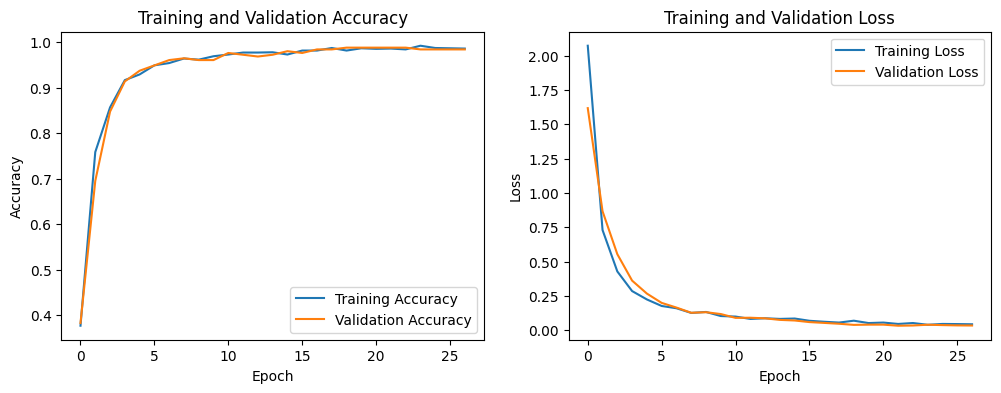

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

img_height, img_width = 160, 160
batch_size = 64
epochs = 30
num_classes = 10

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

steps_per_epoch = train_generator.samples // batch_size
validation_steps = valid_generator.samples // batch_size
test_steps = test_generator.samples // batch_size

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[reduce_lr, early_stopping]
)

test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f'Test accuracy: {test_acc:.2f}')

test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // batch_size + 1, verbose=1)
predicted_classes = np.argmax(preds, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

predicted_classes = predicted_classes[:len(true_classes)]

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

model.save('/content/drive/My Drive/cnn_model_transfer_learning_smallmodel.h5')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 1s 1000ms/step
Image: /content/drive/My Drive/Word/A_BSL2/1.jpeg, Predicted Class: A_BSL
1/1 [==============================] - 0s 42ms/step
Image: /content/drive/My Drive/Word/A_BSL2/2.jpeg, Predicted Class: A_BSL
1/1 [==============================] - 0s 42ms/step
Image: /content/drive/My Drive/Word/A_BSL2/3.jpeg, Predicted Class: A_BSL
Predicted Word: AAA, Language: BSL


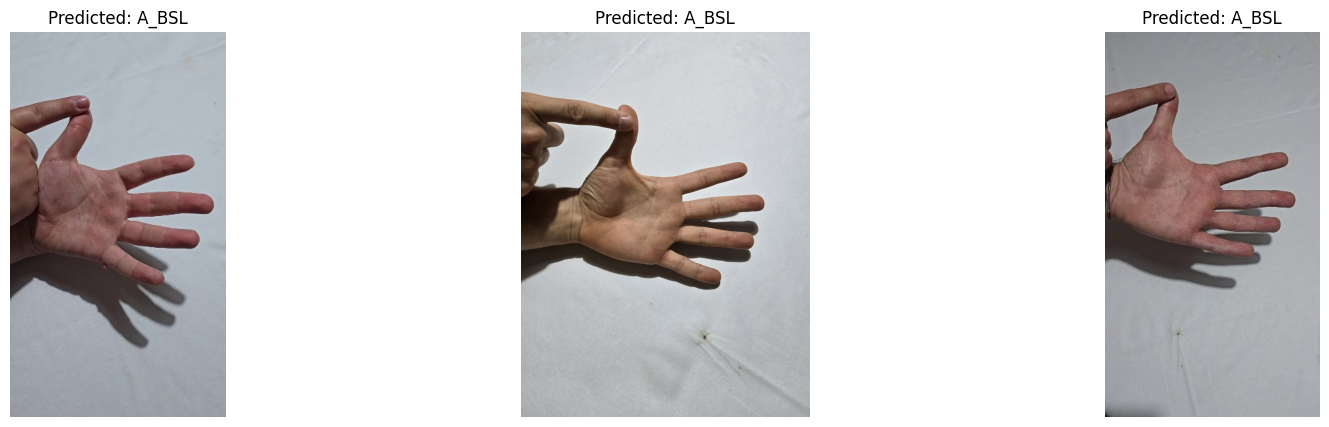

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt

model_path = '/content/drive/My Drive/cnn_model_transfer_learning_smallmodel.h5'
model = load_model(model_path)

image_dir = '/content/drive/My Drive/Word/A_BSL2/'

def preprocess_image(img_path, target_size=(160, 160)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

class_labels_list = ['A_ASL', 'A_BSL', 'B_ASL', 'B_BSL', 'F_ASL', 'F_BSL', 'L_ASL', 'L_BSL', 'R_ASL', 'R_BSL']

class_labels = {i: label for i, label in enumerate(class_labels_list)}

predicted_word = []
predicted_languages = []
predicted_images = []

for i in range(1, 4):
    img_path = os.path.join(image_dir, f'{i}.jpeg')
    processed_img = preprocess_image(img_path)
    prediction = model.predict(processed_img)

    predicted_class_index = np.argmax(prediction, axis=1)[0]

    if predicted_class_index in class_labels:
        predicted_class_label = class_labels[predicted_class_index]
    else:
        print(f"Predicted class index {predicted_class_index} not found in class labels")
        continue

    letter, language = predicted_class_label.split('_')
    predicted_word.append(letter)
    predicted_languages.append(language)

    img = image.load_img(img_path)
    predicted_images.append((img, predicted_class_label))

    print(f"Image: {img_path}, Predicted Class: {predicted_class_label}")

predicted_word_str = ''.join(predicted_word)

if all(lang == 'ASL' for lang in predicted_languages):
    word_language = 'ASL'
elif all(lang == 'BSL' for lang in predicted_languages):
    word_language = 'BSL'
else:
    word_language = 'Mixed'

print(f"Predicted Word: {predicted_word_str}, Language: {word_language}")

plt.figure(figsize=(20, 5))
for idx, (img, label) in enumerate(predicted_images):
    plt.subplot(1, len(predicted_images), idx + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {label}")
    plt.axis('off')
plt.show()


1/1 [==============================] - 1s 1s/step
Image: /content/drive/My Drive/Word/L_ASL/1.jpg, Predicted Class: L_ASL
1/1 [==============================] - 0s 44ms/step
Image: /content/drive/My Drive/Word/L_ASL/2.jpg, Predicted Class: L_ASL
1/1 [==============================] - 0s 49ms/step
Image: /content/drive/My Drive/Word/L_ASL/3.jpg, Predicted Class: L_ASL
Predicted Word: LLL, Language: ASL


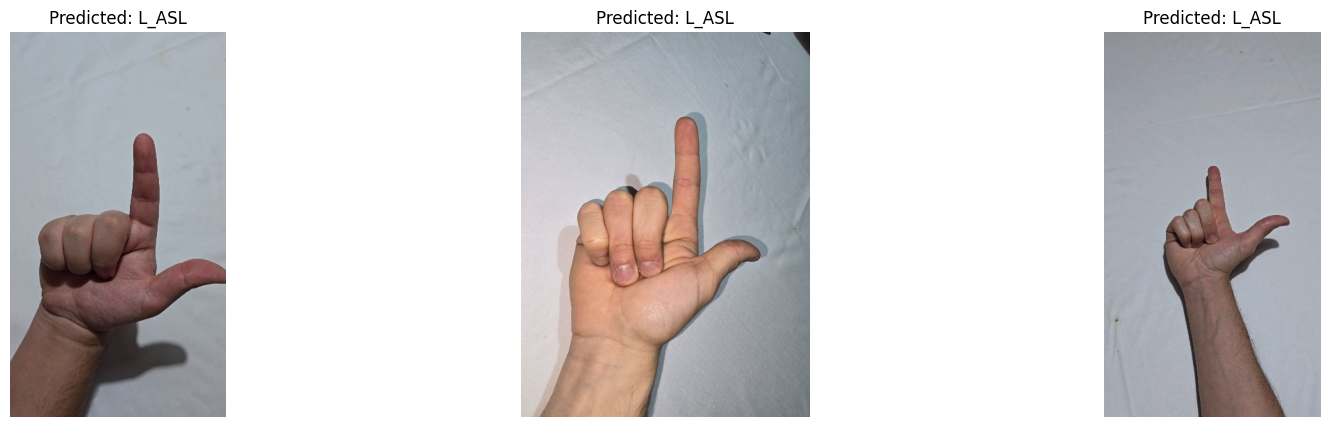

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt

model_path = '/content/drive/My Drive/cnn_model_transfer_learning_smallmodel.h5'
model = load_model(model_path)

image_dir = '/content/drive/My Drive/Word/L_ASL/'

def preprocess_image(img_path, target_size=(160, 160)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

class_labels_list = ['A_ASL', 'A_BSL', 'B_ASL', 'B_BSL', 'F_ASL', 'F_BSL', 'L_ASL', 'L_BSL', 'R_ASL', 'R_BSL']

class_labels = {i: label for i, label in enumerate(class_labels_list)}

predicted_word = []
predicted_languages = []
predicted_images = []

for i in range(1, 4):
    img_path = os.path.join(image_dir, f'{i}.jpg')
    processed_img = preprocess_image(img_path)
    prediction = model.predict(processed_img)

    predicted_class_index = np.argmax(prediction, axis=1)[0]

    if predicted_class_index in class_labels:
        predicted_class_label = class_labels[predicted_class_index]
    else:
        print(f"Predicted class index {predicted_class_index} not found in class labels")
        continue

    letter, language = predicted_class_label.split('_')
    predicted_word.append(letter)
    predicted_languages.append(language)

    img = image.load_img(img_path)
    predicted_images.append((img, predicted_class_label))

    print(f"Image: {img_path}, Predicted Class: {predicted_class_label}")

predicted_word_str = ''.join(predicted_word)

if all(lang == 'ASL' for lang in predicted_languages):
    word_language = 'ASL'
elif all(lang == 'BSL' for lang in predicted_languages):
    word_language = 'BSL'
else:
    word_language = 'Mixed'

print(f"Predicted Word: {predicted_word_str}, Language: {word_language}")

plt.figure(figsize=(20, 5))
for idx, (img, label) in enumerate(predicted_images):
    plt.subplot(1, len(predicted_images), idx + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {label}")
    plt.axis('off')
plt.show()
